### Neighbors-based regression can be used in cases where the data labels are continuous rather than discrete variables. The label assigned to a query point is computed based on the mean of the labels of its nearest neighbors.

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.pipeline import Pipeline

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             2353 non-null   float64
 1   bath            2353 non-null   float64
 2   acre_lot        2353 non-null   float64
 3   zip_code        2353 non-null   float64
 4   house_size      2353 non-null   float64
 5   prev_sold_date  2353 non-null   object 
 6   price           2353 non-null   float64
dtypes: float64(6), object(1)
memory usage: 128.8+ KB


#### Create new feature prev_sold_year from prev_sold_date

In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             2353 non-null   float64
 1   bath            2353 non-null   float64
 2   acre_lot        2353 non-null   float64
 3   zip_code        2353 non-null   float64
 4   house_size      2353 non-null   float64
 5   price           2353 non-null   float64
 6   prev_sold_year  2353 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 128.8 KB


#### Create a new feature in the housing data for Zip Code with a leading zero

#### Create a new feature in the Lat/Long data for Zip Code with a leading zero

In [5]:
zip_lon_lat = pd.read_csv('pa_zip-lon-lat.csv')
zip_lon_lat.head()

,Unnamed: 0,zip_code,latitude,longitude
0,0,16914,41.854230,-76.783664
1,1,16925,41.948556,-76.783808
2,3,18013,40.848762,-75.177293
3,45,18077,40.570065,-75.237114
4,102,18301,41.042703,-75.175581


#### Merge the Lat/Long data with the housing data using Zip Code with a leading zero

In [6]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how='inner', on="zip_code")
merged_df.tail()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,Unnamed: 0,latitude,longitude
2348,3.0,3.0,2.75,18470.0,1913.0,349999.0,2020,187,41.724706,-75.535516
2349,3.0,2.0,4.55,18470.0,1152.0,59000.0,2021,187,41.724706,-75.535516
2350,2.0,2.0,0.05,18421.0,1946.0,85000.0,2022,149,41.664210,-75.492886
2351,2.0,1.0,0.17,18472.0,471.0,98500.0,2021,189,41.583410,-75.396687
2352,3.0,2.0,0.21,18821.0,1175.0,114500.0,2020,253,41.989756,-75.722751


#### Create common variables to store frequently used values.

In [7]:
features = ["latitude", "longitude", "bed","bath","acre_lot","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [8]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [9]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [10]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [11]:
knn_gscv = GridSearchCV(KNeighborsRegressor(), {'n_neighbors': range(40, 50, 1)})

In [12]:
knn_gscv.fit(X,y)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(40, 50)})

In [13]:
print(f"Best parameters found: {knn_gscv.best_params_}")

Best parameters found: {'n_neighbors': 49}


#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [14]:
knn_bp = KNeighborsRegressor(**knn_gscv.best_params_)
knn_bp_gscv = GridSearchCV(knn_bp,param_grid={})
knn_bp_model = knn_bp_gscv.fit(X_train,y_train)
knn_bp_predict = knn_bp_gscv.predict(X_test)

print_more_stuff("KNN Best Params",y_test,knn_bp_predict, knn_bp_gscv)

KNN Best Params EVS = 0.327020996
KNN Best Params MSE = 40,997,915,243.527130
KNN Best Params MAE = 128,653.643522
KNN Best Params R2 = 0.324867
KNN Best Params Fit Time = 0.00312957763671875


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [15]:
knn_sfs = SequentialFeatureSelector(KNeighborsRegressor(), n_features_to_select=num_features_to_select)
knn_sfs.fit(X, y)
knn_sfs_selected_features = knn_sfs.get_support()
print('The selected features are:', list(X.columns[knn_sfs_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'acre_lot', 'prev_sold_year']


#### The default parameters for KNN Regressor are used instead of the best params.

In [16]:
X_sfs = merged_df[list(X.columns[knn_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [17]:
knn_sfs = KNeighborsRegressor()
knn_sfs_gscv = GridSearchCV(knn_sfs,param_grid={})
knn_sfs_model = knn_sfs_gscv.fit(X_sfs_train,y_sfs_train)
knn_sfs_predict = knn_sfs_model.predict(X_sfs_test)

print_more_stuff("Sequential Feature Selector", y_sfs_test, knn_sfs_predict, knn_sfs_gscv)

Sequential Feature Selector EVS = 0.381263855
Sequential Feature Selector MSE = 37,599,952,321.604591
Sequential Feature Selector MAE = 126,328.553824
Sequential Feature Selector R2 = 0.380823
Sequential Feature Selector Fit Time = 0.0015103340148925782


#### Graphing the results works best when the data is provided in a DataFrame.

In [18]:
knn_bp_predict_df = pd.DataFrame(knn_bp_predict).reset_index()
knn_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

knn_sfs_predict_df = pd.DataFrame(knn_sfs_predict).reset_index()
knn_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

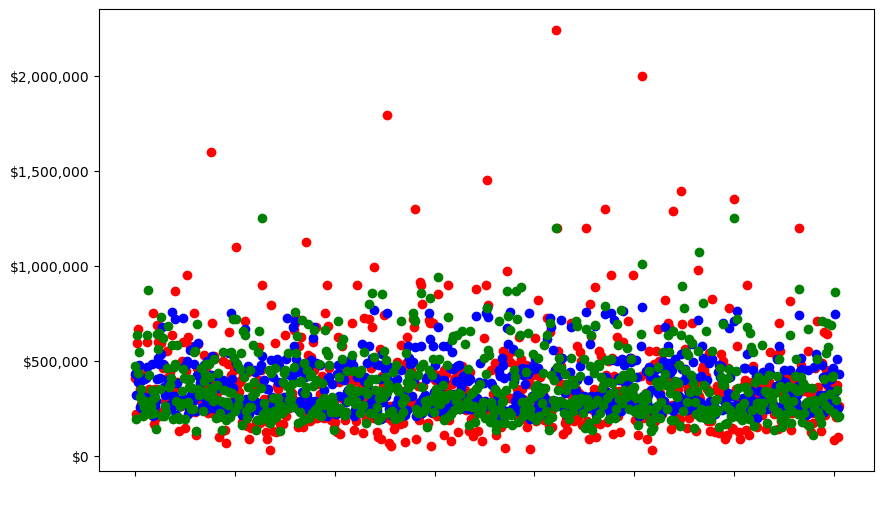

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(knn_bp_predict_df.index,knn_bp_predict_df["prediction"], color="blue")
plt.scatter(knn_sfs_predict_df.index,knn_sfs_predict_df["prediction"], color="green")
plt.show()

#### Sort the DataFrames by the Prediction and Price features.

In [20]:
knn_bp_predict_df.sort_values(by='prediction', inplace=True)
knn_bp_predict_df.reset_index(inplace=True)

knn_sfs_predict_df.sort_values(by='prediction', inplace=True)
knn_sfs_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

#### Line graph of the results of Sequential Feature Selection, and Test Data.

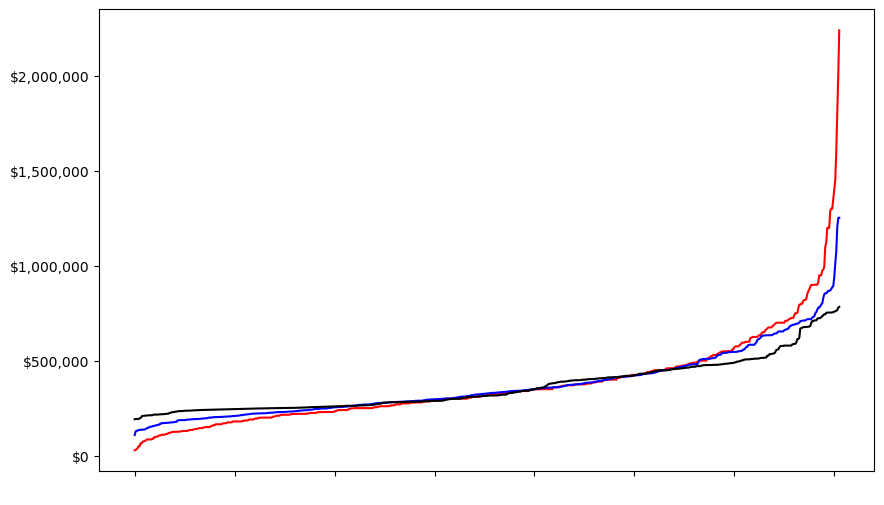

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(knn_sfs_predict_df.index,knn_sfs_predict_df["prediction"], color="blue")
plt.plot(knn_bp_predict_df.index,knn_bp_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [22]:
results_dict

{'model': ['KNN Best Params', 'Sequential Feature Selector'],
 'explained variance score': ['0.327020996', '0.381263855'],
 'mae score': ['128,653.643522', '126,328.553824'],
 'mse score': ['40,997,915,243.527130', '37,599,952,321.604591'],
 'r2 score': ['0.324867', '0.380823'],
 'mean fit time': [0.00312957763671875, 0.0015103340148925782]}

In [23]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
KNN Best Params,0.327020996,"128,653.643522","40,997,915,243.527130",0.324867,0.00313
Sequential Feature Selector,0.381263855,"126,328.553824","37,599,952,321.604591",0.380823,0.00151
